In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas
import math

# make this point to the file with the clean tweets
DATAFILE = "data_clean_stemmed_withoutRT.csv"
# make this point to the file with the text tweets
TWEETSFILE = "data_original_notStemmed_withoutRT.csv"

In [2]:
# import the tweets
text_tweets = pandas.read_csv(TWEETSFILE, index_col=0)
# read the csv
data = pandas.read_csv(DATAFILE, index_col=0)
# get all the tweets
# as of now, they are still strings, the string representation of the list
tweets = []
for tweet in data["text"]:
    tweets.append(eval(tweet))
    
# find all unique words and count them
uniqueWords = {}
total_words = 0
for tweet in tweets:
    for word in tweet:
        total_words += 1
        if word in uniqueWords.keys():
            uniqueWords[word] += 1
        else:
            uniqueWords[word] = 1
print(f"We have {total_words} words, of which {len(uniqueWords.keys())} are unique")
words_tuples = [(word, uniqueWords[word]) for word in uniqueWords.keys()]
words_tuples.sort(reverse=True, key=lambda t: t[1])
print(words_tuples[0:10])

We have 53305 words, of which 4820 are unique
[('great', 832), ('peopl', 433), ('countri', 410), ('border', 351), ('democrat', 342), ('get', 308), ('state', 303), ('presid', 299), ('u', 292), ('trump', 287)]


In [3]:
def explore_clusters(cluster_list, callback=None):
    """Explores the list of clusters provided"""
    # callback is some additional function that gives information about each cluster
    # for example, printing the center of each cluster
    for k, cluster in enumerate(cluster_list):
        tweets_in_cluster = []
        for tweet in data["text"][cluster]:
            tweets_in_cluster.append(eval(tweet))
        # get the unique set of existing words and count those words
        # check the most common ones
        words = {}
        total_words = 0
        for tweet in tweets_in_cluster:
            for word in tweet:
                total_words += 1
                if word in words.keys():
                    words[word] += 1
                else:
                    words[word] = 1
        print(f"We have {total_words} words, of which {len(words.keys())} are unique")
        words_tuples = [(word, words[word]) for word in words.keys()]
        words_tuples.sort(reverse=True, key=lambda t: t[1])

        # plot a histogram of the N most common words
        fig, ax = plt.subplots(figsize=(9,7))
        N = 15
        heights = [tup[1] for tup in words_tuples[:N]]
        words = [tup[0] for tup in words_tuples[:N]]
        indices = list(range(1, 3*N+1, 3))
        bar_width = 2

        ax.barh(indices, heights, bar_width)
        ax.set_yticks(indices)
        ax.set_yticklabels(words)
        ax.set_title(f"Most common tweet words in cluster {k}")
        
        if callback:
            callback(k)

        some_tweet_idx = random.sample(cluster, 5)
        for idx in some_tweet_idx:
            print(str(idx) + " - " + (text_tweets["text"][idx]))
        print("-"*40)

In [4]:
# create the one-hot encoding of each tweet
# start by fixing some ordering of the words
orderedWords = uniqueWords.keys()
mat = []
for tweet in tweets:
    one_hot_enc = []
    for word in orderedWords:
        one_hot_enc.append(1 if word in tweet else 0) # most of these will be 0s
    mat.append(one_hot_enc)

In [5]:
# get a more time-efficient (but more memory-consuming) way of retrieving
# the different PCAs, for different numbers of components:
def get_pca(n):
    cached = get_pca.memory.get(n, None)
    if cached is not None:
        return cached
    else:
        pca = PCA(n_components = n, random_state=3534)
        reduced = pca.fit_transform(mat)
        get_pca.memory[n] = reduced
        return reduced
get_pca.memory = dict()

D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_dista

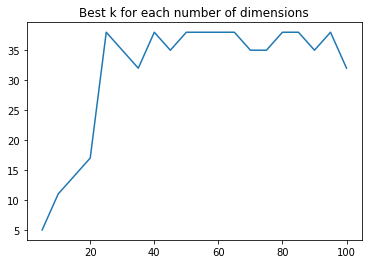

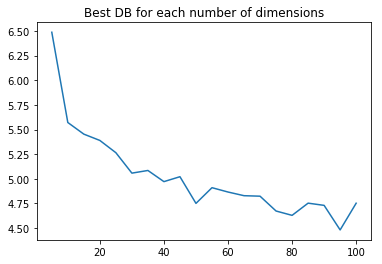

In [19]:
best_ks = []
best_DB = []
test_ns = range(5,101,5)
for ncomps in test_ns:
    reduced = get_pca(ncomps)

    # apply the KMeans algorithm to the reduced data for different values of K
    K = range(2,40,3)
    DB = np.zeros_like(K).astype(float)
    for i, k in enumerate(K):
        kmeans = KMeans(n_clusters = k, random_state=73).fit(reduced)
        with np.errstate(divide='ignore'):
            DB[i] = davies_bouldin_score(mat, kmeans.labels_)
    best_ks.append(K[np.argmin(DB)])
    best_DB.append(np.min(DB))
    # use PCA to reduce the dimension
    reduced = get_pca(ncomps)

plt.plot(test_ns, best_ks)
plt.title("Best k for each number of dimensions")
plt.show()
plt.plot(test_ns, best_DB)
plt.title("Best DB for each number of dimensions")
plt.show()

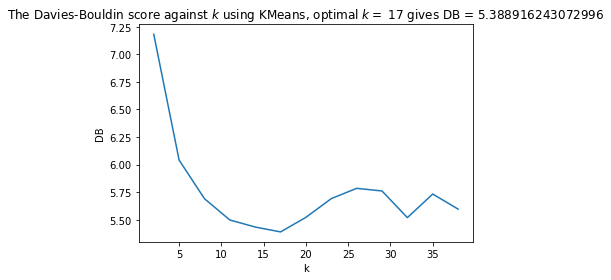

[143, 165, 80, 126, 147, 111, 183, 176, 100, 166, 156, 71, 123, 100, 151, 805, 232]
We have 3049 words, of which 803 are unique
1612 - So we now find out that it was indeed the unverified and Fake Dirty Dossier, that was paid for by Crooked Hillary Clinton and the DNC, that was knowingly &amp; falsely submitted to FISA and which was responsible for starting the totally conflicted and discredited Mueller Witch Hunt!
1183 - How the hell is Bruce Ohr still employed at the Justice Department? Disgraceful!  Witch Hunt!
1337 - “The FBI received documents from Bruce Ohr (of the Justice Department &amp; whose wife Nelly worked for Fusion GPS).” Disgraced and fired FBI Agent Peter Strzok. This is too crazy to be believed! The Rigged Witch Hunt has zero credibility.
1609 - .....”Carter Page wasn’t a spy, wasn’t an agent of the Russians - he would have cooperated with the FBI. It was a fraud and a hoax designed to target Trump.” Tom Fitton @JudicialWatch A disgrace to America. They should drop th

1404 - The big story that the Fake News Media refuses to report is lowlife Christopher Steele’s many meetings with Deputy A.G. Bruce Ohr and his beautiful wife, Nelly. It was Fusion GPS that hired Steele to write the phony &amp; discredited Dossier, paid for by Crooked Hillary &amp; the DNC....
2970 - Despite some very corrupt and dishonest media coverage, there are many great reporters I respect and lots of GOOD NEWS for the American people to be proud of!
1454 - The Fake News hates me saying that they are the Enemy of the People only because they know it’s TRUE. I am providing a great service by explaining this to the American People. They purposely cause great division &amp; distrust. They can also cause War! They are very dangerous &amp; sick!
816 - The crowd in front of the U.S. Supreme Court is tiny, looks like about 200 people (&amp; most are onlookers) - that wouldn’t even fill the first couple of rows of our Kansas Rally, or any of our Rallies for that matter! The Fake News Me

120 - Russia Dossier reporter now doubts dopey Christopher Steele’s claims! “When you get into the details of the Steele Dossier, the specific allegations, we have not seen the evidence to support them. There’s good grounds to think that some of the more sensational allegations.....
905 - US-Korea Free Trade Agreement Signing Ceremony! https://t.co/yLFkAZgagG
822 - Just out: 3.7% Unemployment is the lowest number since 1969!
2277 - Happy Mother’s Day!!! https://t.co/zw71dnT7TJ
1459 - Heading to Ohio!
----------------------------------------
We have 3428 words, of which 1305 are unique
2515 - Last night, it was my great honor to host America’s senior defense and military leaders for dinner at the White House. America’s military is the GREATEST fighting force in the history of the world. They all have my pledge of unwavering commitment to our men and women in uniform! https://t.co/BjWKcMX0iL
1995 - Our Great Larry Kudlow, who has been working so hard on trade and the economy, has just su

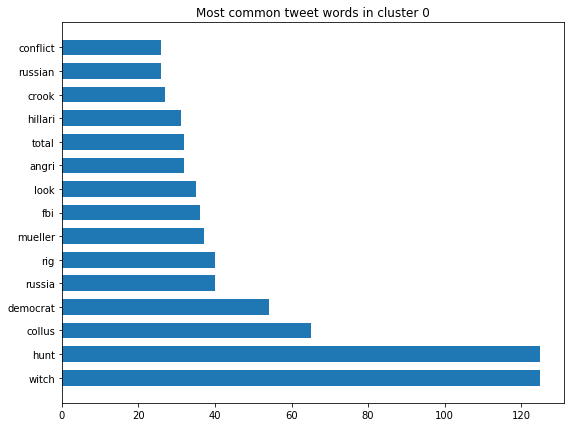

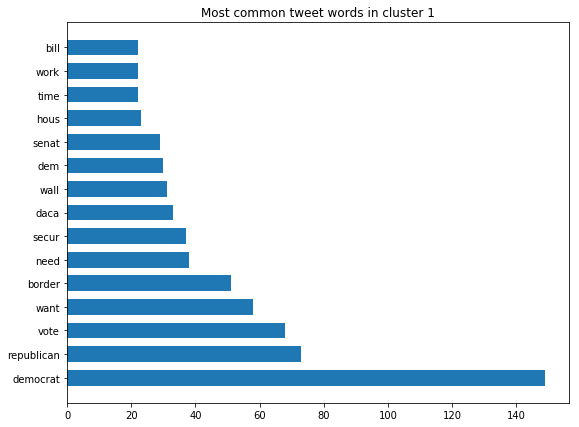

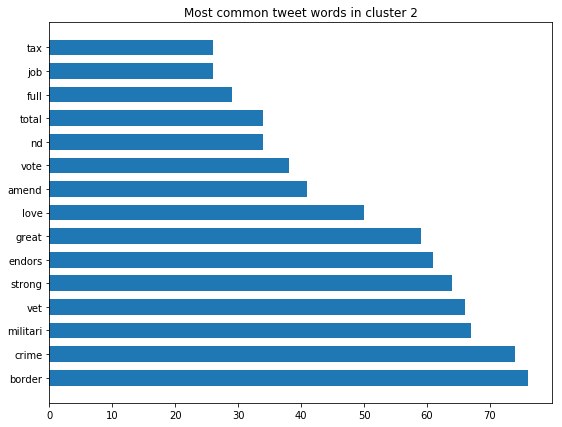

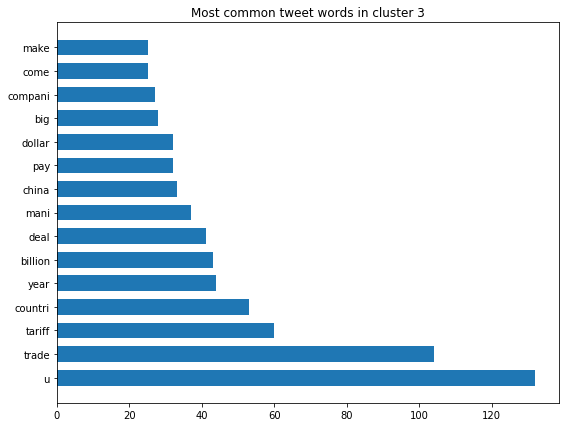

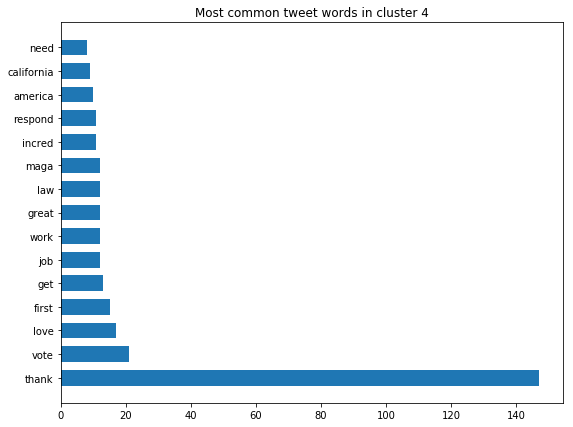

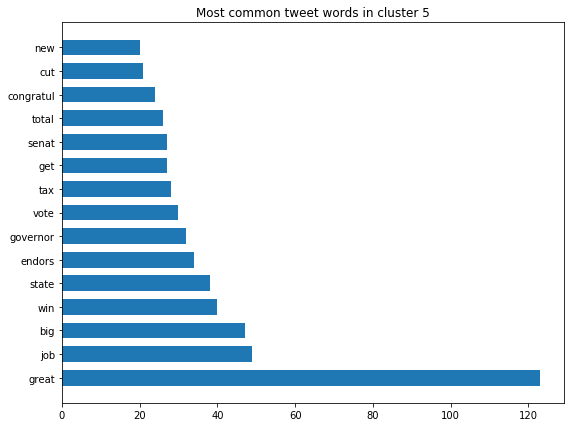

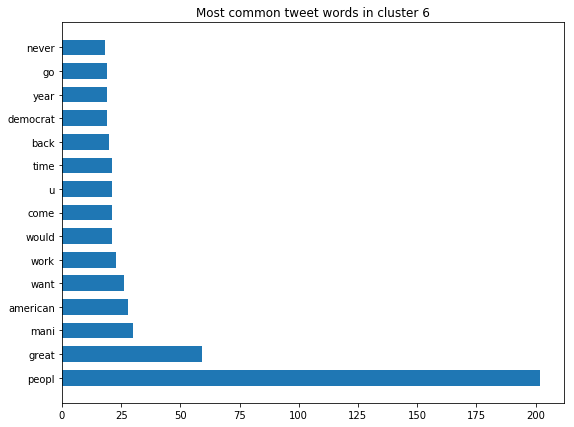

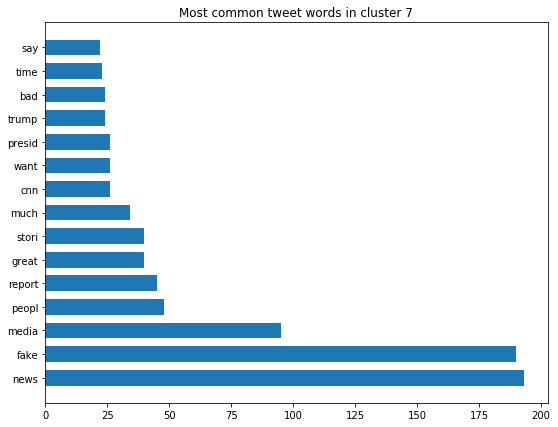

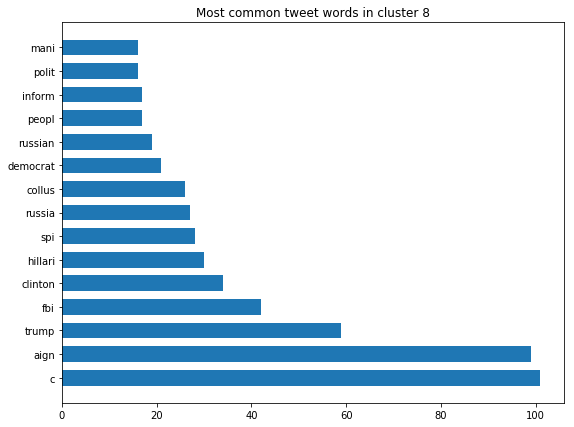

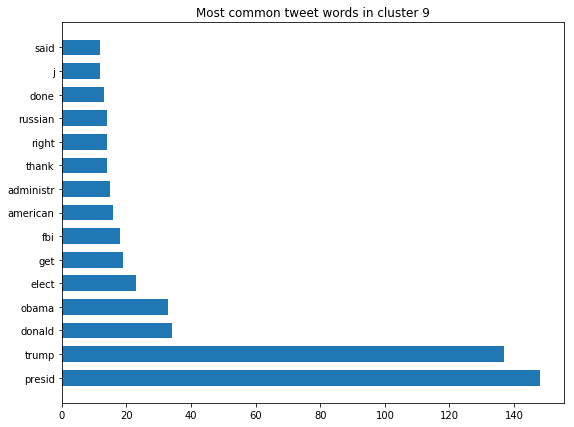

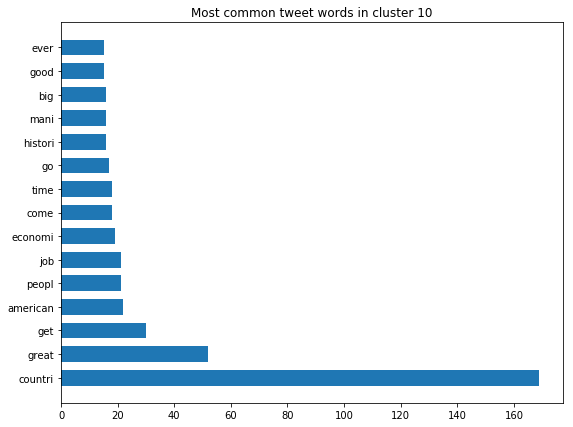

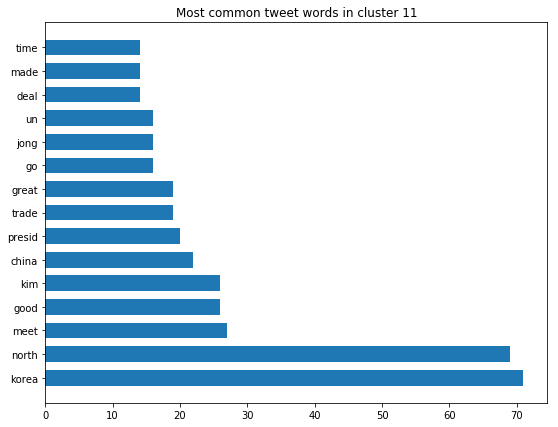

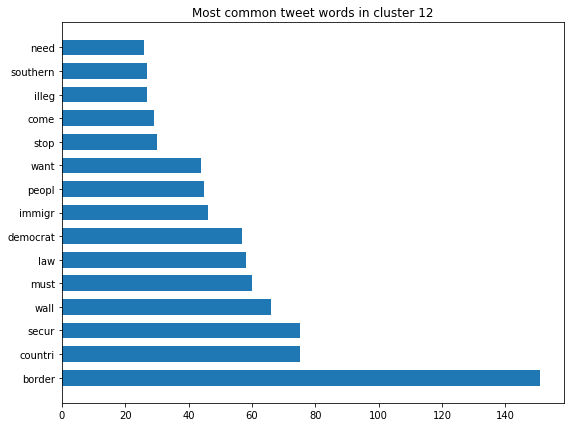

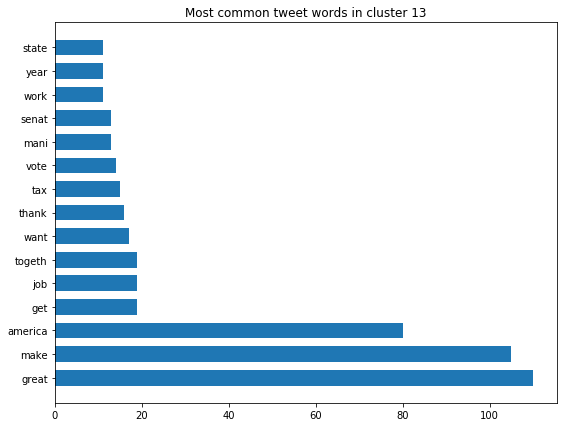

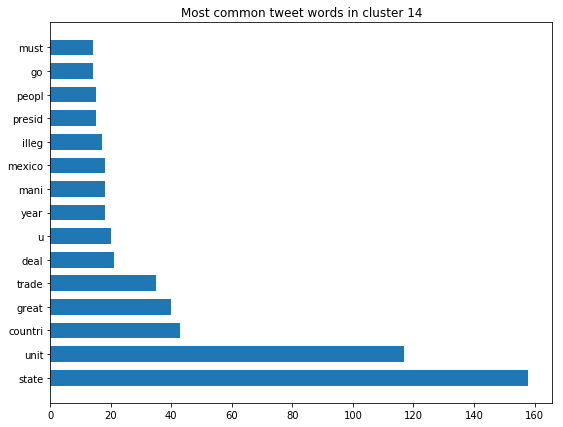

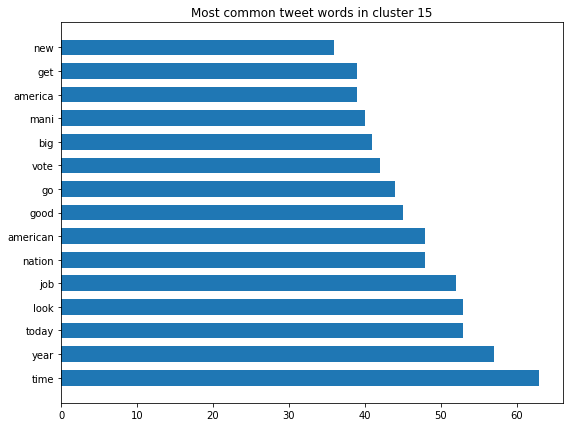

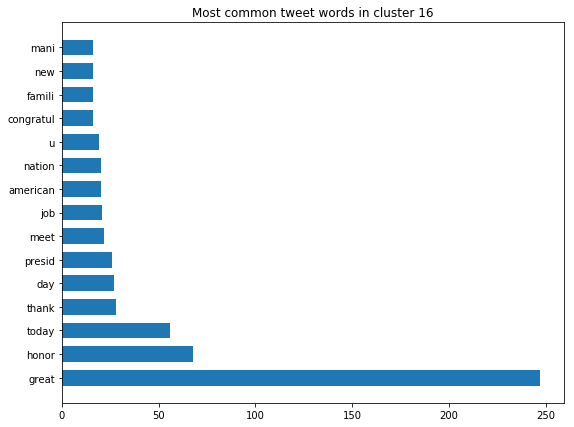

In [6]:
reduced = get_pca(20)

# apply the KMeans algorithm to the reduced data for different values of K
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
for i, k in enumerate(K):
    kmeans = KMeans(n_clusters = k, random_state=73).fit(reduced)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, kmeans.labels_)
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'The Davies-Bouldin score against $k$ using KMeans, optimal $k = $ {k_opt} gives DB = {np.min(DB)}')
plt.show()


kmeans = KMeans(n_clusters = k_opt, random_state=73).fit(reduced)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, sk_clusters)))



random.seed(52345234)
# take some random tweets from every cluster
explore_clusters(sk_clusters)

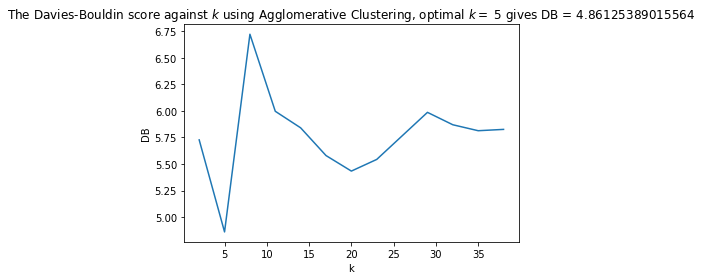

[2435, 99, 191, 177, 133]
We have 39843 words, of which 4502 are unique
1535 - ...and the Amazon Washington Post do nothing but write bad stories even on very positive achievements - and they will never change!
2122 - Very importantly, @RepDanDonovan will win for the Republicans in November...and his opponent will not. Remember Alabama. We can’t take any chances on losing to a Nancy Pelosi controlled Democrat!
1657 - While the NATO meeting in Brussels was an acknowledged triumph, with billions of dollars more being put up by member countries at a faster pace, the meeting with Russia may prove to be, in the long run, an even greater success. Many positive things will come out of that meeting..
2594 - THE SECOND AMENDMENT WILL NEVER BE REPEALED! As much as Democrats would like to see this happen, and despite the words yesterday of former Supreme Court Justice Stevens, NO WAY. We need more Republicans in 2018 and must ALWAYS hold the Supreme Court!
546 - Stock Market up more than 400 poin

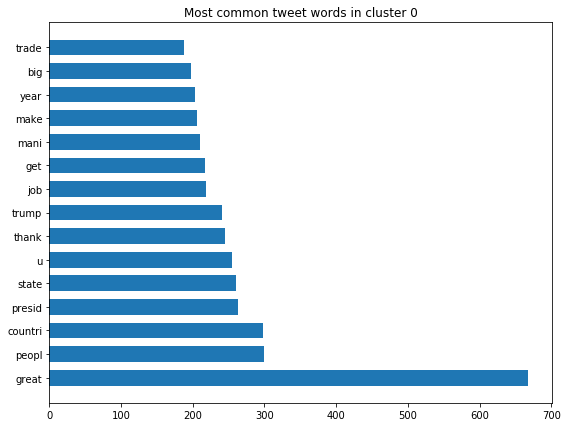

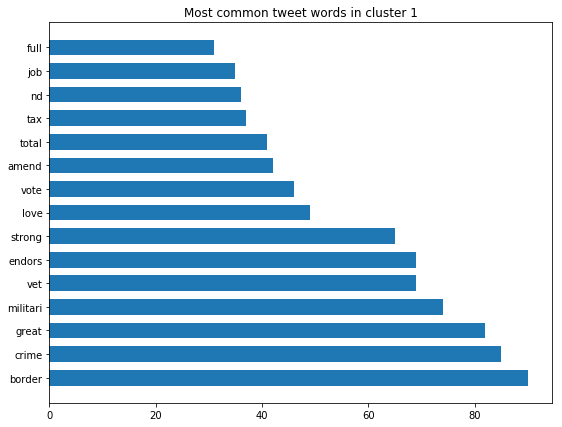

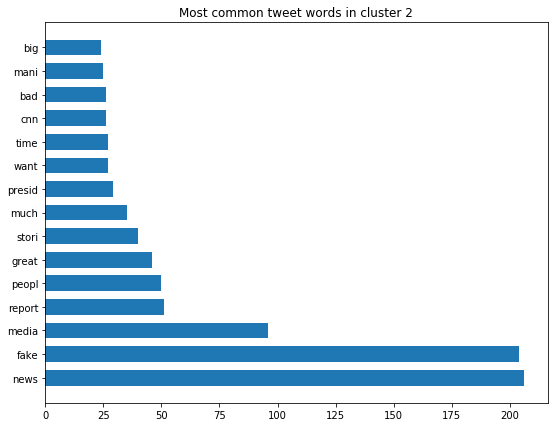

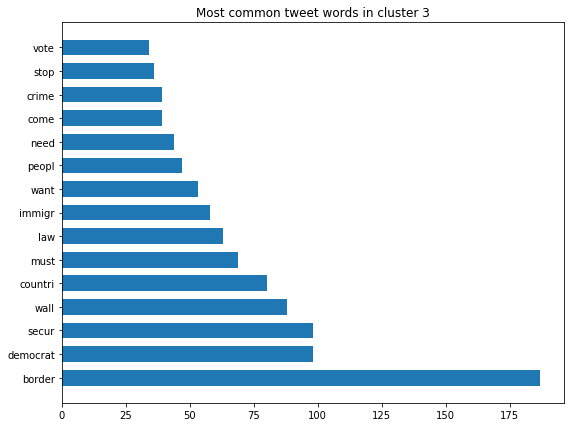

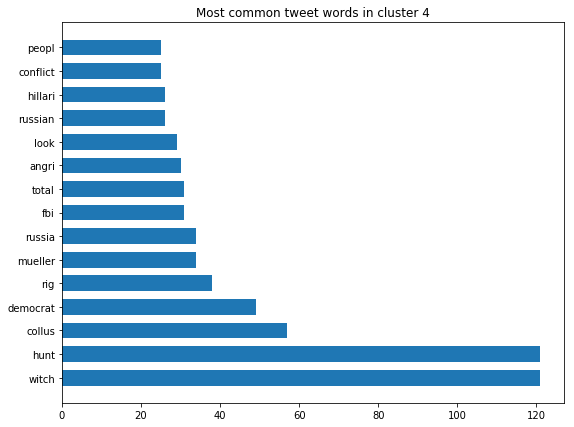

In [7]:
reduced = get_pca(20)
# apply 

# apply agglomerative clustering to the reduced data for different values of k (n_clusters)
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
i = 0
for k in K:
    kmeans = AgglomerativeClustering(n_clusters = k).fit(reduced)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, kmeans.labels_)
    i += 1
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'The Davies-Bouldin score against $k$ using Agglomerative Clustering, optimal $k = $ {k_opt} gives DB = {np.min(DB)}')
plt.show()

agg = AgglomerativeClustering(n_clusters=k_opt).fit(reduced)
agg_clusters = [[] for i in range(max(agg.labels_+1))]
for idx, lbl in enumerate(agg.labels_):
    agg_clusters[lbl].append(idx)

print(list(map(len, agg_clusters)))

random.seed(162323)
# take some random tweets from every cluster
explore_clusters(agg_clusters)

[276, 56, 1420, 30, 1253]
We have 3818 words, of which 1382 are unique
1696 - A very nice note from Chairman Kim of North Korea. Great progress being made! https://t.co/6NI6AqL0xt
973 - Join me in Las Vegas, Nevada at 7:00pm for a MAKE AMERICA GREAT AGAIN RALLY! Tickets: https://t.co/keENWZEd0F https://t.co/xJzQ9foOTL
2600 - .@HowieCarrShow just wrote a book which everyone is talking about. He was a great help. He is a veteran journalist who had a great influence in NH and beyond. He calls it the most amazing political campaign of modern times. The book is called, “What Really Happened.” Enjoy! #MAGA https://t.co/jYhjpoJKHe
2052 - Gold Star father, Ceejay Metcalf, whose great son Michael was just honored at the White House, was fantastic this morning on @foxandfriends. He is a special man!
2607 - France honors a great hero. Officer died after bravely swapping places with hostage in ISIS related terror attack. So much bravery around the world constantly fighting radical Islamic terroris

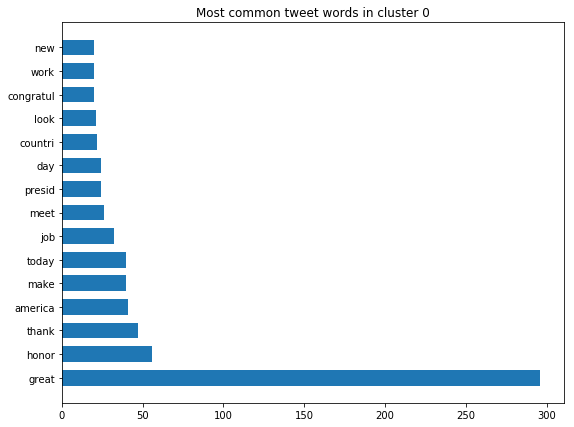

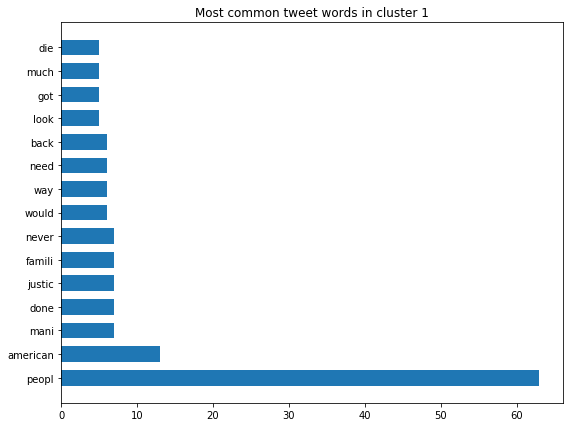

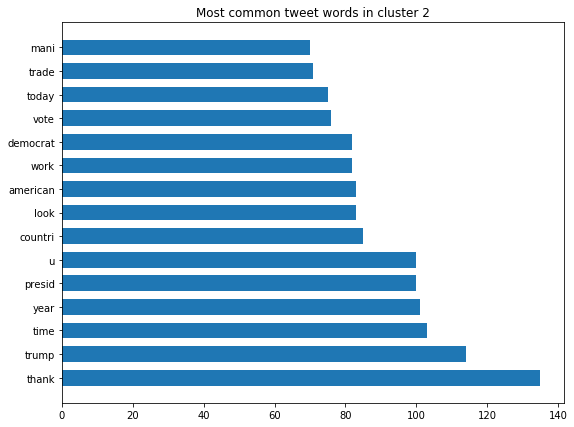

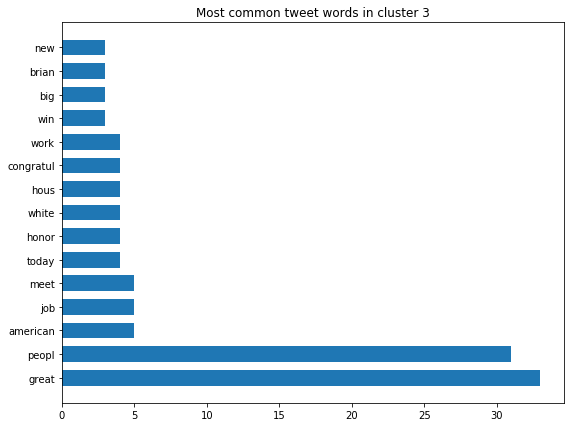

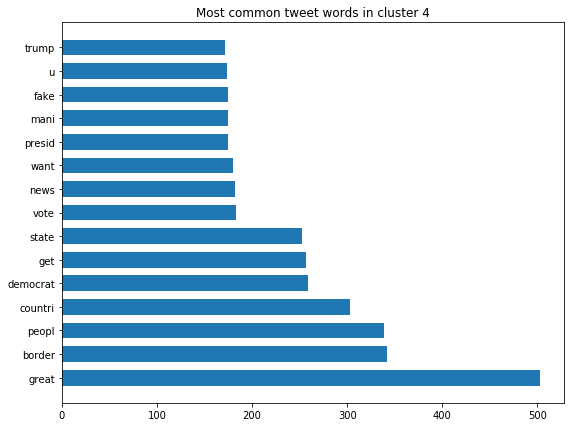

In [9]:
# from the prints above, this should give a "small" number
# of clusters while also mantaining them as evenly sized as possible
reduced = get_pca(11)
# apply the DBSCAN algorithm to the reduced data
dbscan = DBSCAN(min_samples=10).fit(reduced)
dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
for idx, lbl in enumerate(dbscan.labels_):
    dbscan_clusters[lbl].append(idx)
    
print(list(map(len, dbscan_clusters)))

random.seed(3452314)
# take some random tweets from every cluster
explore_clusters(dbscan_clusters)